# Predicting bike availability for San Francisco's bike share program
Bike share programs are cropping up in cities across the world, providing a flexible transportation option for professionals and tourists alike. Bike share systems are commonly build with docking stations throughout the city where users can check out and return bikes. San Francisco launched their bike share program in 2013 and, as of 2015, had 70 stations throughout the city. The program makes the following data publically available (source: https://www.kaggle.com/benhamner/sf-bay-area-bike-share/data): 
- status: minute by minute update of the number of bike and number of docks available for each of the 70 stations
- weather: daily weather patterns for the 4 zip codes in the SF bike share program
- station: metadata for each station (n = 70)
- trips: one record for each bike trip. Includes date, station ID, station name for the start and end points, as well as the bike id, rider subscription type, and the trip duration.

Bike system data present lots of exicting potential analyses - like optimizing location on future bike stations, and helping the city allocate bikes across stations (to ensure bike availability, cities often manually transport bikes between statinos with lots of bikes and expected low demand, to stations with few bikes and anticipated high demand).
This project focuses on user-centered challenges.

Bike share programs are notoriously unreliable - riders can't always anticipate that the bike will be available at their preferred docking station when they will arrive. With an uncertain supply of bikes, ridership demand can stagnate. This project builds and evaluates two models to predict bike availability (within 30 minutes of a request) for the San Francisco bike share system. 

In [985]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta 
import scipy.optimize as optimization
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

In [262]:
# import raw data. 
status = pd.DataFrame.from_csv('data/0/ouput.csv', index_col = None)
weather = pd.DataFrame.from_csv('data/0/weather.csv', index_col = None)
station = pd.DataFrame.from_csv('data/0/station.csv', index_col = None)
trips = pd.DataFrame.from_csv('data/0/trips.csv', index_col = None)

Clean up the status, weather and trip data for EDA. Due to file size, wrangling of the status data was performed outside of the notebook (described below). 

In [917]:
trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4069,174,8/29/2013 9:08,2nd at South Park,64,8/29/2013 9:11,2nd at South Park,64,288,Subscriber,94114
1,4073,1067,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:42,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703
2,4074,1131,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115
3,4075,1117,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122
4,4076,1118,8/29/2013 9:25,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597


In [289]:
status['datetime'] = pd.to_datetime(status.time)
del status['time']
status['datetime'] = status.datetime.map(lambda x: x.replace(second=0))

In [ ]:
weather['date'] = pd.to_datetime(weather['date'])
weather['week'] = weather['date'].dt.week

In [7]:
df_trips = trips.drop(['start_station_name', 'end_station_name'], axis=1)
df_trips['start_date'] = pd.to_datetime(df_trips['start_date'])
df_trips['dow'] = df_trips['start_date'].dt.dayofweek
df_trips['week'] = df_trips['start_date'].dt.week
df_trips['dow'] = df_trips['start_date'].dt.dayofweek
df_trips['hour'] = df_trips['start_date'].dt.hour
df_trips.head()

,id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type,zip_code,dow,week,hour
0,4069,174,2013-08-29 09:08:00,64,8/29/2013 9:11,64,288,Subscriber,94114,3,35,9
1,4073,1067,2013-08-29 09:24:00,66,8/29/2013 9:42,69,321,Subscriber,94703,3,35,9
2,4074,1131,2013-08-29 09:24:00,66,8/29/2013 9:43,69,317,Subscriber,94115,3,35,9
3,4075,1117,2013-08-29 09:24:00,66,8/29/2013 9:43,69,316,Subscriber,94122,3,35,9
4,4076,1118,2013-08-29 09:25:00,66,8/29/2013 9:43,69,322,Subscriber,94597,3,35,9


### Exploratory data analysis
The following graphs demonstrate the bike demand for various time intervals. Ridership (number of trips) is segmented by the rider's subscription type: Subscriber (has a monthly or annual membership), and Customer (casual pay-as-you-go rider). The time series plots provide paint a consistent story that Subscribers are residents commuting to work while Customers are likely tourists: 
1. Daily trends 2013-2015: Overall, ridership has increased over the two years since the bike share scheme was implemented. Customer ridership is seasonal, peaking in Aug/Sept/Oct and with a lull around the holidays). This could be due to weather (fall is notoriously the warmest season in SF), tourism trends (coinciding with the warmer months), and a drop off in usage for casual bike commuters during the winter holidays. 
2. Annual trend (grouped by total weekly rides): Annual trends reflect the same pattern seen in the overall historical trends. As expected, ridership amongst subscribers (presumably professionals commuting to work) drops off at a few main times throughout the year, coinciding with key holidays: week 22 (coinciding with Memorial Day), week 27 (July 4th), week 36 (Labor day), weeks 46/47 (Thanksgiving), and weeks 51/52 (Christmas and New Years). With the exclusion of the holiday slow-downs, ridership increased slightly throughout the year, peaking in the summer (around weeks 34/35) when the weather in the Bay Area is typically the most conducive to biking. This can be confirmed with weather patterns. Customer ridership, on the other hand, has local maximum during holidays and a global maximum during the Labor Day holiday period. Ridership also increases slightly throughout the year, dropping off in the fall. 
The weekly and hourly graphs further supports the hypothesis that Subscribers are commuters and Customers are likely tourists: 
3. Weekly trend: Subscriber ridership is highest on weekdays, about 5x the standard weekend ridership. Customers, however, see about twice as many rides on weekends as during the beginning of the week. 
4. Hourly trend: Subscriber data shows a very distinct bi-modal hourly usage with peaks during morning commute hours and afternoon commute hours. To a lesser degree, Subscribers also have a small increase in activity during lunch hours. Customers get a later start (as you would on vacation), with an almost steady usage throughout from 11am until the early evening. 

In [8]:
# check for missing data
station.isnull().values.any()

False

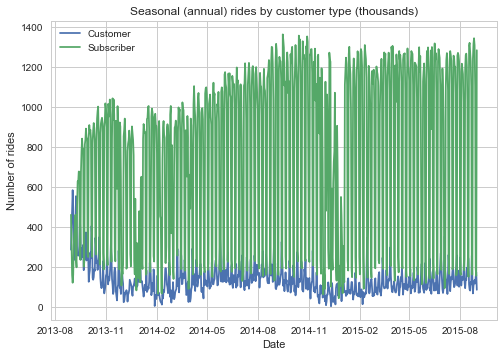

In [9]:
# Seasonal ridership by subscription model
t = df_trips.groupby([df_trips['start_date'].dt.date, 'subscription_type']).size()
t = t.unstack('subscription_type')

sns.set_style("whitegrid")
_ = plt.plot(t)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of rides')
_ = plt.title('Seasonal (annual) rides by customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

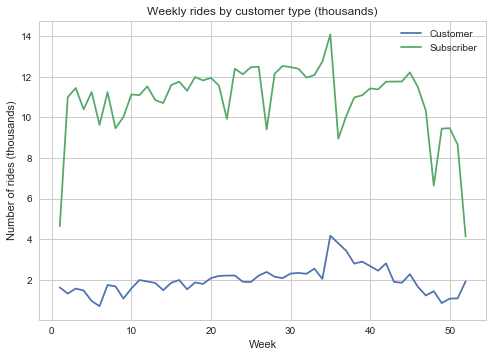

In [10]:
# Weekly ridership by subscription model
t = df_trips.groupby(['week', 'subscription_type']).size()
t = t.unstack('subscription_type')

sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Weekly rides by customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

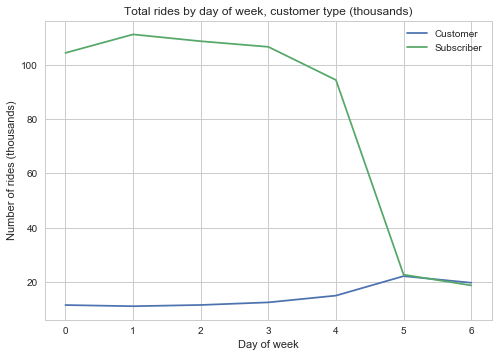

In [11]:
# Daily ridership by subscription model
t = df_trips.groupby(['dow', 'subscription_type']).size()
t = t.unstack('subscription_type')

# sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Day of week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Total rides by day of week, customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

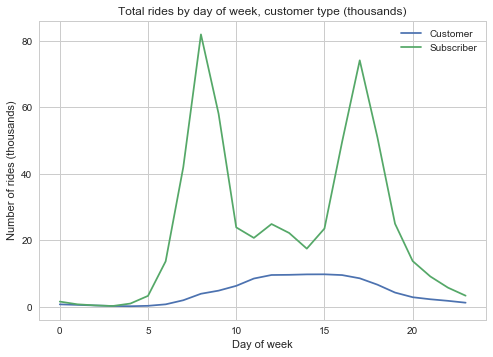

In [12]:
# Hourly ridership by subscription model
t = df_trips.groupby(['hour', 'subscription_type']).size()
t = t.unstack('subscription_type')

# sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Day of week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Total rides by day of week, customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

ValueError: could not convert string to float: '9/9/2014'

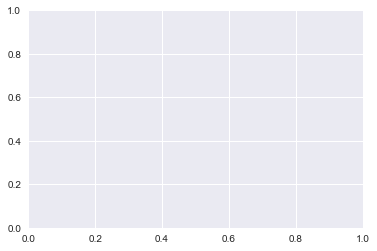

In [1018]:
# w = weather.unstack(level='zip_code')
w = weather.groupby(['date', 'zip_code']).mean()
w = w.unstack('zip_code')

_ = plt.plot(w.mean_temperature_f)
_ = plt.xlabel('Week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Average weekly mean temperature')
plt.show()

## Simple deterministic model
For comparison agains the machine learning model, a deterministic model was created to predict bike availability. This model calculates a per-station change in bike availabilitiy for nine 30-minute intervals.
- The 30-minute intervals represent key commuter times (based on the daily traffic plotted in the EDA section above) when demand is highest: 
    - Morning: 7:30, 8, 8:30, 9am
    - Evening: 4, 4:30, 5, 5:30, 6pm
- The least squares fit line was calculated for each station and 30-minute interval 
- Predicted bike availability was calucated as the sum of: current bike availability and the slope of the least squares line (x 30 mins)
- Predicted bike availablility was compared to the actual number of available bikes at t+30 minutes

### Model creation

In [542]:
# initialize variables 
def func(x, a, b):
    return a + b*x
start_times = ['07:30:00', '08:00:00','08:30:00','09:00:00', '16:00:00', '16:30:00','17:00:00','17:30:00','18:00:00']
delta = pd.Timedelta(29, unit='m')

station_ids = status_dtIndex.station_id.unique()
n_bikes = 2
dow = 3
dom = 9

In [371]:
# create subset of status df per station
def station_availability(station_id, n_bikes, dow):    
    s = status[status.station_id == station_id]
    # create master df of dock status, with dt index 
    s.index = s['datetime']
    s.index = s.index.map(lambda x: x.replace(second=0))
    return s
# test_set.bikes_available[test_set.bikes_available <1].value_counts()

In [797]:
# popt_all_stations = pd.DataFrame()
popt_all_stations = []
row_headers = []

for i in station_ids:
    s = station_availability(i, n_bikes= n_bikes, dow= dow)       
    popt_single = []
    for j in times:
        start_time = pd.to_datetime(j)
        end_time = start_time + delta
        df = s.between_time(start_time.time(), end_time.time())
        xdata = df.index.minute
        ydata = np.array(df.bikes_available)
        popt, pcov = optimization.curve_fit(func, xdata, ydata)
        popt_single.append(popt[1])
    popt_all_stations.append(popt_single)
    row_headers.append(i)
    
# reshape the model df with time as col headers, station as index
df = pd.DataFrame(popt_all_stations)
df.columns = times
df.index = row_headers
model = df*30

In [858]:
model = pd.melt(model2, id_vars = ['station_id'])

### Model evaluation
Generated test dataset for model evaluation outside of the notebook (see step-wise python processing files in data/x/), with the following operations: 
- Parsed datetimes
- Generated test data set: 
    - Filter to specific day of week (dow)
    - In line with the machine learning model, divide the data 70:30 into training & test data, where test data includes the first 30% of the month (days 1-9) 
- New column ['model_time']: Mapped appropriate model time to status updates (if status update occurs within 30 minutes of a given model time); narrow down status updates to only those assigned a model
- New column ['biked_in_30_mins']: Mapped the true number of bikes at a station 30 minutes after the status time (timestamp)

In [935]:
pd.read_csv('data/3/output.csv', header=None, names =['station_id','current_bikes','docks_available', 'timestamp', 'model_time','actual_bikes_in_30']).head()

,station_id,current_bikes,docks_available,timestamp,model_time,actual_bikes_in_30
0,2,9,18,1.378298e+09,07:30:00,9
1,2,9,18,1.378298e+09,07:30:00,9
2,2,9,18,1.378298e+09,07:30:00,7
3,2,9,18,1.378298e+09,07:30:00,7
4,2,9,18,1.378298e+09,07:30:00,7


In [876]:
# import processed csv
df_eval = pd.read_csv('data/3/output.csv', header=None, names =['station_id','current_bikes','docks_available', 'timestamp', 'model_time','actual_bikes_in_30'])

In [887]:
def binary_bike_availability(x):
    if x>=n_bikes:
        return 1
    else: return 0

df_eval = df_eval.merge(model, how='left', left_on= ['model_time','station_id'], right_on = ['variable','station_id'])
df_eval['actual_binary'] = df_eval.actual_bikes_in_30.apply(binary_bike_availability)
df_eval.rename(columns = {'variable':'slope'}, inplace=True)
df_eval['predicted_bikes_in_30'] = df_eval.current_bikes + df_evaluation.slope
df_eval['predicted_binary'] = df_eval.predicted_bikes_in_30.apply(binary_bike_availability)
del df_eval['value']

In [916]:
accuracy = metrics.accuracy_score(df_eval.actual_binary, df_eval.predicted_binary)

print('Deterministic model predicts 30-min availability with {0:.2f}% accuracy'.format(accuracy*100))

Deterministic model predicts 30-min availability with 95.90% accuracy


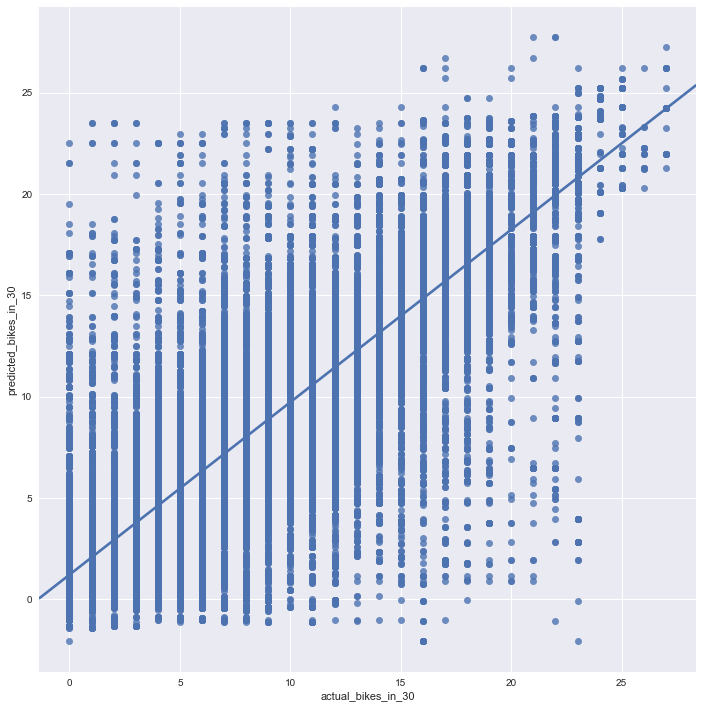

In [894]:
sns.pairplot(df_eval, x_vars = ['actual_bikes_in_30'], 
             y_vars = ['predicted_bikes_in_30'], size = 10, kind = 'reg')

## Machine Learning model

In [1012]:
df_ml = pd.read_csv('data/4/output.csv', header=None, names =['station_id','current_bikes',
                                                              'docks_available', 'timestamp', 
                                                              'model_time','actual_bikes_in_30', 
                                                              'day_of_week', 'month', 'commute_hours'])

,station_id,current_bikes,docks_available,timestamp,model_time,actual_bikes_in_30,day_of_week,month,commute_hours


In [1005]:
def format_time(x):
    x = int(x)
    return datetime.datetime.fromtimestamp(x).time().isoformat()

#reformat timestampe (for QC)
df_ml.timestamp = df_ml.timestamp.apply(format_time)

# create binary target variable for bike availability
df_ml['y'] = df_ml.actual_bikes_in_30.apply(binary_bike_availability)

# remove columns used to generate target variable
del df_ml['timestamp'] 
del df_ml['model_time']
del df_ml['actual_bikes_in_30']

In [1007]:
y = df_ml.y.values.reshape(-1,1)
X = df_ml.drop(['y'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 
lr = LinearRegression()

In [1008]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

cv_results = cross_val_score(lr, X, y, cv = 5)
print('Model accuracy with 5 cross validation folds: {}' .format(np.mean(cv_results)))

# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lr.coef_[0,:]})[['features', 'estimatedCoefficients']]

Model accuracy with 5 cross validation folds: 0.03583650517474683


,features,estimatedCoefficients
0,station_id,-0.000306
1,current_bikes,0.003934
2,docks_available,-0.002402
3,day_of_week,0.002589
4,month,0.000049
5,commute_hours,-0.001080


regenerating the test set - with all time slots - not just the ones associated with models (irrelevant for the ML model)